In [86]:
# import os

# for veg in os.listdir("data"):
#     path = os.path.join("data", veg)
#     if not os.path.isdir(path):
#         continue
#     for cam in os.listdir(path):
#         path = os.path.join("data", veg, cam)
#         if not os.path.isdir(path):
#             continue
#         for day in os.listdir(path):
#             path = os.path.join("data", veg, cam, day)
#             if not os.path.isdir(path):
#                 continue
#             for file in os.listdir(path):
#                 dirs = os.path.join("data2", "Avocado", cam, day)
#                 if not os.path.exists(dirs):
#                     os.makedirs(dirs)
#                 old_path = os.path.join("data", veg, cam, day, file)
#                 new_path = os.path.join(dirs, file)
#                 os.rename(old_path, new_path)

In [87]:
import os
import numpy as np
from spectral import envi
import json

with open("train_only_labeled.json", "r") as f:
    data = json.load(f)

annotations = data["annotations"]
records = data["records"]
cameras = data["cameras"]
vis_wls = cameras[0]["wavelengths"]
nir_wls = cameras[1]["wavelengths"]

ripeness_mapping = {"unripe": 0, "perfect": 1, "overripe": 2}

X = []
Y = []

for annotation in annotations:
    record = next((r for r in records if r["id"] == annotation["record_id"]), None)
    if record:
        try:
            image = envi.open(
                f"data/{record["files"]["header_file"]}",
                image=f"data/{record["files"]["data_file"]}",
            )
            X.append({"image": image.load(), "camera": record["camera_type"]})
            Y.append(ripeness_mapping[annotation["ripeness_state"]])
        except Exception as e:
            print(f"Error loading image: {e}")

X = np.array(X, dtype=object)
Y = np.array(Y, dtype=int)

print(f"Loaded dataset: {len(X)} samples.")

Error loading image: Unable to locate file "data/Kiwi/NIR/day_01/kiwi_day_01_03_front.hdr". If the file exists, use its full path or place its directory in the SPECTRAL_DATA environment variable.
Error loading image: Unable to locate file "data/Kiwi/VIS/day_01/kiwi_day_01_03_front.hdr". If the file exists, use its full path or place its directory in the SPECTRAL_DATA environment variable.
Error loading image: Unable to locate file "data/Kiwi/NIR/day_01/kiwi_day_01_03_back.hdr". If the file exists, use its full path or place its directory in the SPECTRAL_DATA environment variable.
Error loading image: Unable to locate file "data/Kiwi/VIS/day_01/kiwi_day_01_03_back.hdr". If the file exists, use its full path or place its directory in the SPECTRAL_DATA environment variable.
Error loading image: Unable to locate file "data/Kiwi/NIR/day_01/kiwi_day_01_28_front.hdr". If the file exists, use its full path or place its directory in the SPECTRAL_DATA environment variable.
Error loading image: U

In [88]:
X[0]["image"].shape

(219, 94, 252)

/Users/jakubdulas/Documents/Studia/AOC/FruitsClassificationFromHipespectralImages/.venv/lib/python3.12/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


(315, 188, 252)

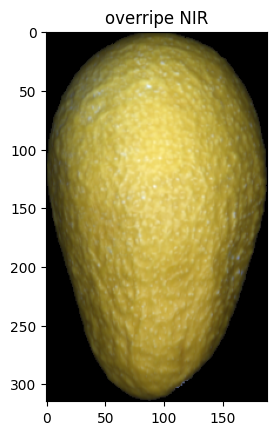

In [89]:
from spectral import imshow

index = list(Y).index(2)
# index = 1
label = {v: k for k, v in ripeness_mapping.items()}[Y[index]] + " " + X[index]["camera"]
x = X[index]["image"]
imshow(x, bands=(30, 80, 151), title=label)
x.shape

Text(0.5, 1.0, 'overripe NIR')

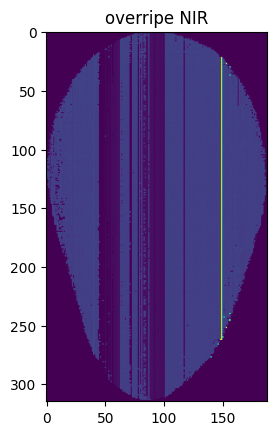

In [90]:
import matplotlib.pyplot as plt


plt.imshow(x.asarray().argmax(2))
plt.title(label)

In [91]:
X1 = []
Y1 = []

for x, y in zip(X, Y):
    if x["camera"] == "VIS":
        X1.append(x)
        Y1.append(y)

X1 = np.array(X1, dtype=object)
Y1 = np.array(Y1, dtype=int)

print(f"Loaded dataset: {len(X1)} samples.")

Loaded dataset: 92 samples.


(286, 294, 224)

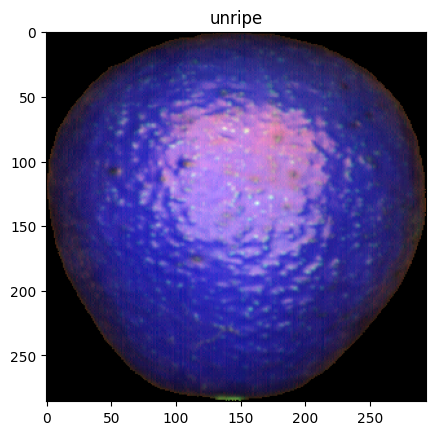

In [92]:
index = list(Y).index(0)
label = {v: k for k, v in ripeness_mapping.items()}[Y1[index]]
x = X1[index]["image"]
imshow(x, bands=(30, 80, 151), title=label)
x.shape

Text(0.5, 1.0, 'unripe')

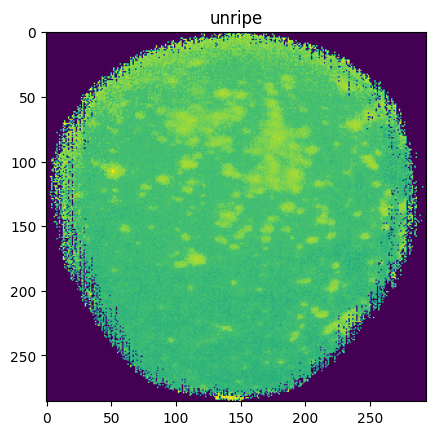

In [93]:
plt.imshow(x.asarray().argmax(2))
plt.title(label)

In [94]:
X2 = []
for x in X1:
    X2.append(
        [
            [
                (vis_wls[i] if x["image"].asarray()[r_idx][i_idx][0] != 0 else None)
                for i_idx, i in enumerate(r)
            ]
            for r_idx, r in enumerate(x["image"].asarray().argmax(2))
        ]
    )
X2 = np.array(X2, dtype=object)

In [95]:
from collections import Counter

x = [item for sublist in X2[0] for item in sublist]
counter = Counter(x)
counter.pop(None)
counter = {k: v for k, v in sorted(dict(counter).items(), key=lambda x: x[0])}

In [96]:
def image_to_features(x):
    x = [item for sublist in x for item in sublist]
    counter = Counter(x)
    counter.pop(None)
    counter = {k: v for k, v in sorted(dict(counter).items(), key=lambda x: x[0])}
    features = np.array([counter.get(wl, 0) for wl in vis_wls], dtype=np.float64)
    return features

In [97]:
X3 = []
for x in X2:
    features = image_to_features(x)
    X3.append(features)
X3 = np.array(X3, dtype=object)

In [98]:
X3.shape, Y1.shape

((92, 224), (92,))

In [99]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X3)

In [100]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=30)

# X_pca = pca.fit_transform(X_scaled)

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X3, Y1, test_size=0.2)

In [108]:
X_train[11]

array([1101.0, 849.0, 499.0, 314.0, 158.0, 93.0, 37.0, 13.0, 4.0, 2.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 16.0, 45.0, 95.0, 159.0,
       189.0, 103.0, 55.0, 77.0, 127.0, 186.0, 574.0, 1549.0, 3181.0,
       3253.0, 2117.0, 1057.0, 839.0, 1092.0, 2051.0, 4713.0, 8923.0,
       10756.0, 13114.0, 10881.0, 5112.0, 1582.0, 279.0, 77.0, 35.0, 

In [103]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
X_test, y_test = ros.fit_resample(X_test, y_test)

In [104]:
Counter(y_test)

Counter({np.int64(1): 11, np.int64(2): 11, np.int64(0): 11})

In [105]:
Counter(y_train)

Counter({np.int64(1): 39, np.int64(2): 39, np.int64(0): 39})

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=15, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=1000, max_features=1000, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

In [110]:
print(y_test)
for classifier in classifiers:
    classifier = classifier.fit(X_train, y_train)
    print(classifier.predict(X_test))
    print(classifier.score(X_test, y_test))

[1 1 1 1 2 0 0 1 2 1 2 1 2 1 0 1 0 1 1 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
[1 2 2 1 2 0 0 1 2 1 2 0 2 1 0 1 0 1 1 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
0.9090909090909091
[1 2 1 1 2 0 0 1 2 1 1 1 2 2 1 1 0 2 1 1 0 0 1 1 0 0 2 1 2 1 1 1 1]
0.6060606060606061
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.3333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
0.3333333333333333
[1 2 1 1 2 0 1 1 0 1 2 1 2 2 1 1 0 1 1 1 0 0 1 1 0 0 2 2 0 2 2 2 2]
0.7272727272727273
[1 2 1 1 2 0 0 1 0 1 2 0 2 2 1 1 0 1 1 1 0 0 1 1 0 0 2 2 0 2 2 2 2]
0.7272727272727273
[2 2 1 1 2 0 0 1 2 1 2 0 2 1 0 1 0 1 1 0 0 0 0 0 0 0 2 2 2 2 2 2 2]
0.9090909090909091
[2 2 2 2 2 0 0 1 2 1 2 0 2 1 1 1 0 1 1 1 0 0 1 1 0 0 2 2 2 2 2 2 2]
0.7272727272727273
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1]
0.42424242424242425


/Users/jakubdulas/Documents/Studia/AOC/FruitsClassificationFromHipespectralImages/.venv/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
